# Run Me
pip install openpyxl,
pip install graphviz,
sudo apt-get update && sudo apt-get upgrade

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["PATH"] += os.pathsep + "/usr/local/python/3.10.4/lib/python3.10/site-packages/graphviz"

In [5]:
def f(x):
    return 3*x**2 - 4*x+5

In [6]:
f(3.0)

20.0

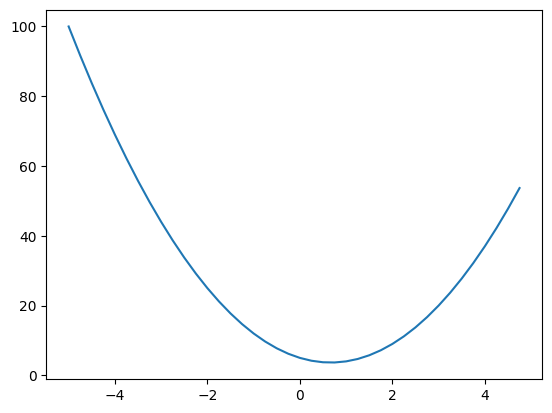

In [7]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs,ys)

In [8]:
h = 0.001
x = 2/3
(f(x + h) - f(x))/h


0.0029999999995311555

In [9]:
a = 2.0
b = -3.0
c = 10.0
d = a*b +c
d

4.0

In [10]:
h=0.0001

a = 2.0
b = -3.0
c = 10.0


d1 = a*b +c
a+=h
d2 = a*b +c

print('d1',d1)
print('d2',d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [11]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), _op = '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data, (self, other), _op = '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self,other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), label=f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other): # fixes other + self  (2.__add__(a))
        return self + other
    
    def __rmul__(self, other): # fixes other * self  (2.__mul__(a))
        return self * other

    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self,other): # self - other
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1 )/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out


    def backward(self):
        
        # Topological sorting for a grap (Making lay out Left to right) to prep for backprop

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()    


In [12]:
a = Value(2.0)
b = 1

b + a



Value(data=3.0)

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e= a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

In [13]:
!pip install openpyxl


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [14]:
!pip install graphviz



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [15]:
from graphviz import Digraph

# builds a set of all nodes and edges within a graph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name= uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [18]:
!sudo apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
The following packages were automatically installed and are no longer required:
  aspnetcore-runtime-6.0 aspnetcore-targeting-pack-6.0 dotnet-apphost-pack-6.0
  dotnet-host dotnet-hostfxr-6.0 dotnet-runtime-6.0 dotnet-runtime-deps-6.0
  dotnet-targeting-pack-6.0 netstandard-targeting-pack-2.1
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


What is the derivitive of d with respect to L?
L = d * f
dL/dd =? f

Derivitive formula:
(f(x+h)-f(x))/h

((d+h)*f - d*f)/h
(d*f + h*f = d*f)/h
h*f/h
f


What is the derivitive of c with respect to L?
dL / dc
dd / dc ??  <--- local derivitive  

d = c + e

Derivitive formula:
(f(x+h)-f(x)) / h

((c+h) + e) - (c+e)/h
(c + h + e - c + e) / h
h/h
1.0

Which implies 
dd / de = 1.0 


Using Chain Rule

WANT:
dL / dc = (dL/dd) * (dd/dc)

KNOW:
dL / dd
dd / dc

What is the derivitive of a with respect to L?

dL / de = -2.0
dL / da = (dL/de) * (de/da)


In [21]:
# 26:46

L.grad=1.0
f.grad=4.0
d.grad=-2.0
c.grad = -2.0
e.grad = -2.0
a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)

In [22]:
def lol():

    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e= a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e= a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data + h

    print((L2-L1)/h)
lol()    

1.000000000000334


a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad
e = a * b
d = e + c
L = d * f

print(L.data)

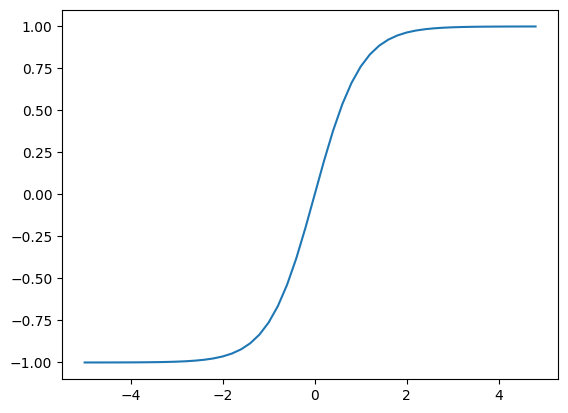

In [24]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));
plt.grid;
# Our Activation function

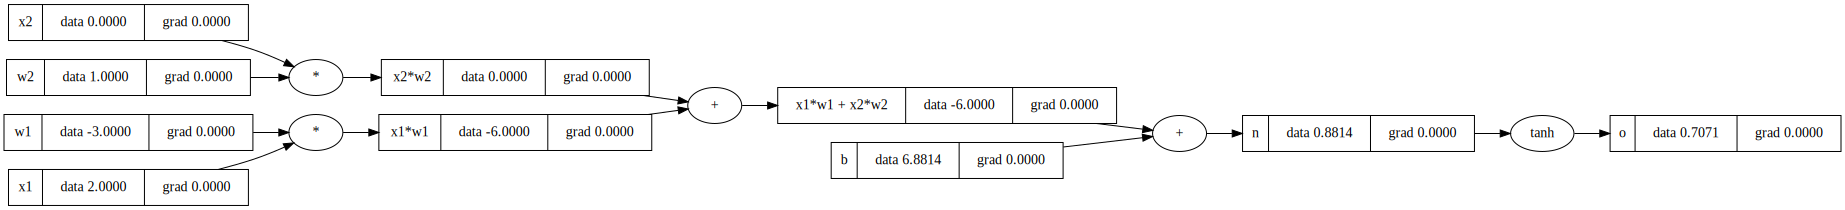

In [25]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

# x1*w1 + x2*w2 + b
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n= x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

draw_dot(o)

# Manually backpropigating the graph

o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

# Tanh Activation Function

o.grad = 1.0
# o = tanh(n)
# do/dn = 1 o **2

1 - o.data**2

# Manually doing Backpropigation
n.grad = 0.5

# Plus node distributes
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
b.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [26]:
# Topological sorting for a grap (Making lay out Left to right) to prep for backprop

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

o.grad = 1.0

# Topological sorting for a grap (Making lay out Left to right) to prep for backprop

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

draw_dot(o)

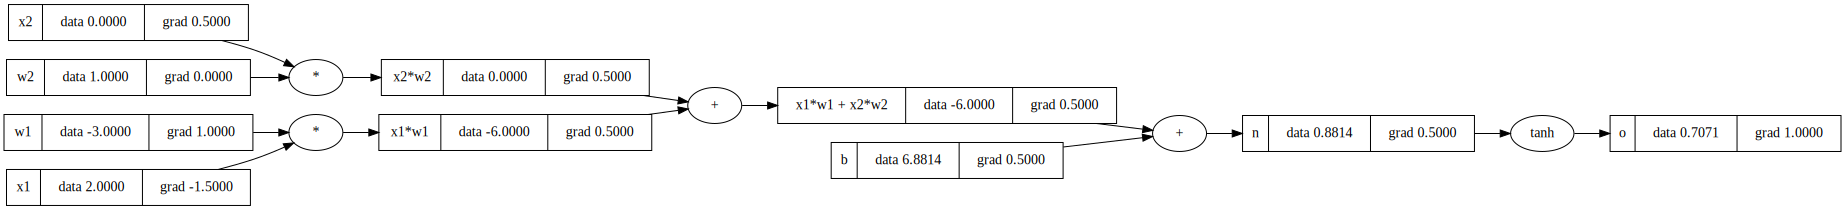

In [27]:
o.backward()
draw_dot(o)

1:20:00

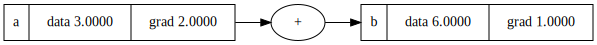

In [28]:
a = Value(3.0, label='a')
b = a+a; b.label='b'
b.backward()
draw_dot(b)

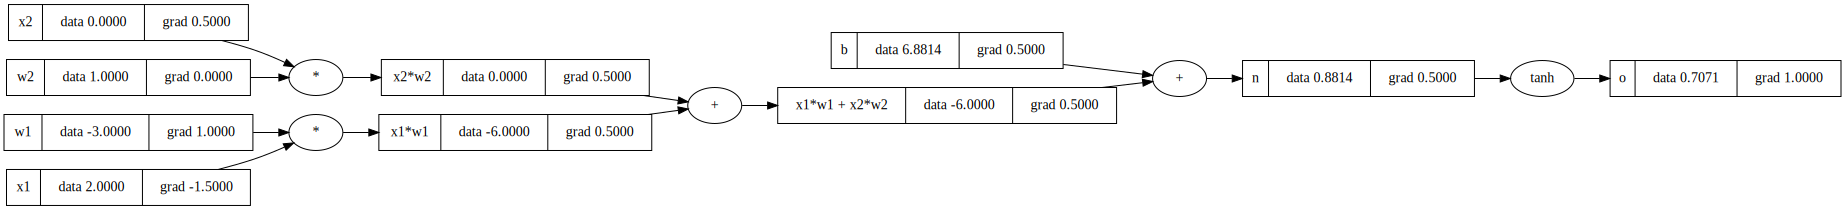

In [29]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

# x1*w1 + x2*w2 + b
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n= x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

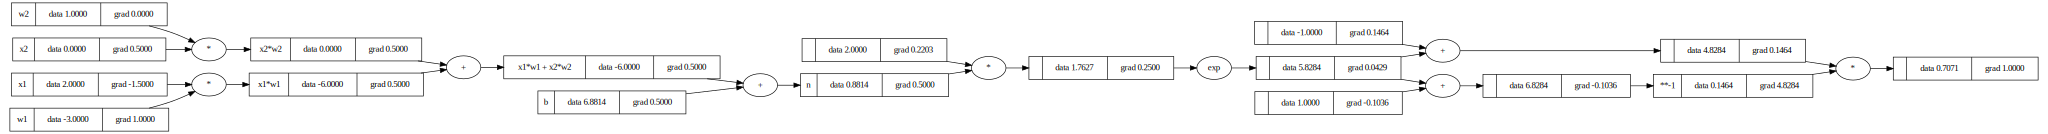

In [30]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

# x1*w1 + x2*w2 + b
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n= x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)


o.backward()

draw_dot(o)

In [31]:
import torch

In [32]:
x1 = torch.Tensor([2.0]).double()  ; x1. requires_grad = True
x2 = torch.Tensor([0.0]).double()  ; x2. requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ; w1. requires_grad = True
w2 = torch.Tensor([1.0]).double()  ; w2. requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b. requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
x1 -1.5000003851533106
w1 1.0000002567688737
w2 0.0


In [33]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [34]:
import random

In [35]:
class Neuron:

    def __init__(self, nin): # nin = number of inputs into the neuron
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b =  Value(random.uniform(-1,1))

    def __call__(self, x): # Neuron(x)
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    def __init__(self, nin, nout): # nout = number of outputs (aka how many neurons do u want in this specific layer)
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x): # Layer(x)
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP: # Multi Layer Perceptron
    def __init__(self, nin , nouts): # nouts is a list in this case
        sz = [nin] + nouts # size?
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [36]:
x =[2.0, 3.0]
n = MLP(3, [4 , 4 , 1])
n(x)

Value(data=0.11975445792950366)

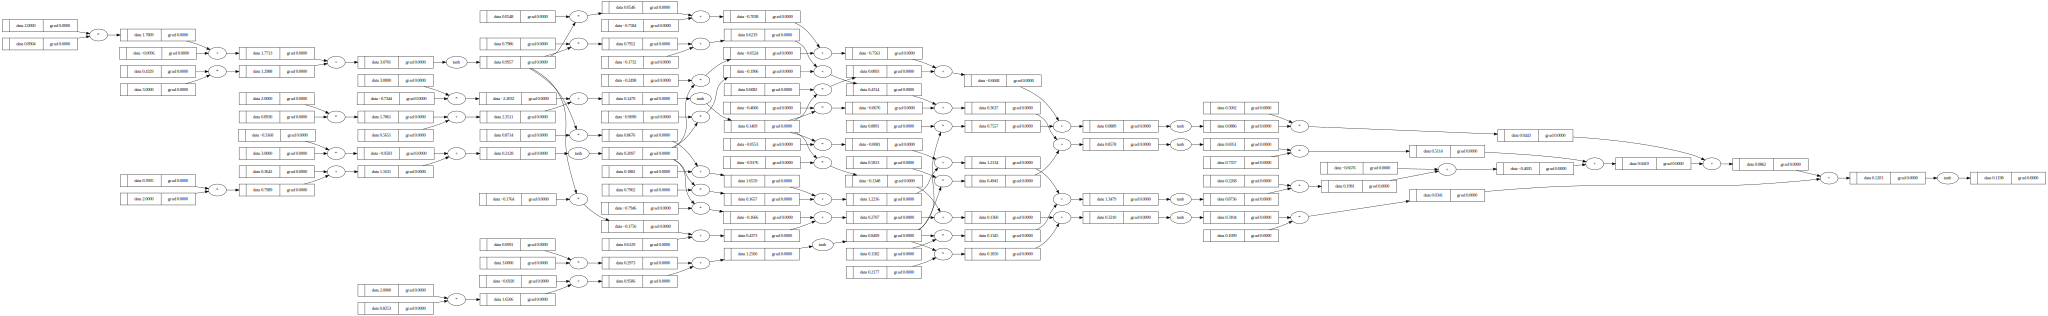

In [37]:
draw_dot(n(x))

In [38]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets (binary classifier neural network)


In [39]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))  # mean squared error loss.  - ygt = y ground truth - low loss is better
loss

Value(data=1.9061155699564987)

In [56]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))  # mean squared error loss.  - ygt = y ground truth - low loss is better
    loss

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.005794305564479735
1 0.005740940018220741
2 0.005688520376820917
3 0.005637021976616735
4 0.005586420999169966
5 0.005536694435496955
6 0.005487820052094675
7 0.005439776358659391
8 0.005392542577400598
9 0.0053460986138592625
10 0.00530042502914489
11 0.005255503013512033
12 0.005211314361201463
13 0.005167841446476142
14 0.005125067200786286
15 0.005082975091002079
16 0.00504154909865678
17 0.005000773700145131
18 0.004960633847827295
19 0.004921114951989644


In [57]:
ypred

[Value(data=0.9730494337979272),
 Value(data=-0.9560043613927129),
 Value(data=-0.983926012255057),
 Value(data=0.9552697794003903)]